# Text Classification using Naive Bayes

## Libraries

In [1]:
library(jsonlite)
library(dplyr)
library(formatR)
library(tidyverse)
library(reshape)
library(qdap)
library(textclean)
library(tm)
library(stringi)
library(caret)
library(e1071)
library(stopwords)
library(tokenizers)
library(wordcloud)
library(RColorBrewer)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v readr   1.1.1
v tibble  1.4.2     v purrr   0.2.5
v tidyr   0.8.1     v stringr 1.3.1
v ggplot2 3.1.0     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()

Attaching package: 'reshape'

The following objects are masked from 'package:tidyr':

    expand, smiths

The following object is masked from 'package:dplyr':

    rename

Loading required package: qdapDictionaries
Loading required package: qdapRegex

Attaching package: 'qdapRegex'

The following object is masked from 'package:ggplot2':

    %+%

The following object i

## Data Collection

### Collect Data from 6 different sections

In [2]:
api = 'https://content.guardianapis.com/search?'
api_key = '0e9a8c4e-1866-4503-a9eb-70e391c499c4'
page_size = '200'

pages = c(1:5)

queries = c('business','politics','science','technology','sport','news')

news_data = data.frame()

for(query in queries){
  for (page in pages){
    url = paste(api, 'section=', query, '&page-size=', page_size, '&page=', page, '&show-fields=body', '&api-key=', api_key, 
                sep = "")
    json = fromJSON(url)
    body = as.data.frame(json$response$results$fields)
    json$response$results$fields = NULL
    data = as.data.frame(json$response$results)
    data = cbind(data,body)
    news_data = rbind(news_data,data)
  }
  
  select_data = select(data, c("sectionName","pillarName","webTitle"))
  print(paste("Table containing",toupper(query)," News"))
  print(head(select_data))
  cat("\n")
}

[1] "Table containing BUSINESS  News"
  sectionName pillarName
1    Business       News
2    Business       News
3    Business       News
4    Business       News
5    Business       News
6    Business       News
                                                                webTitle
1 Number of US companies disclosing political donations reaches new high
2        Royal Mail share price sinks further after profit warning shock
3           Shell approves $12bn liquefied natural gas project in Canada
4       Primera Air collapse: what are my rights and can I get a refund?
5     Toyota says hard Brexit would halt UK plant as BMW warns over Mini
6                   Why did £300 disappear from my John Lewis gift card?

[1] "Table containing POLITICS  News"
  sectionName pillarName
1    Politics       News
2    Politics       News
3    Politics       News
4    Politics       News
5    Politics       News
6    Politics       News
                                                              

### Display the summary of the collected data

In [3]:
count = news_data%>%
  group_by(sectionName)%>%
  tally
print("Table containing sections and their counts") 
print(count)

[1] "Table containing sections and their counts"
# A tibble: 6 x 2
  sectionName     n
  <chr>       <int>
1 Business     1000
2 News         1000
3 Politics     1000
4 Science      1000
5 Sport        1000
6 Technology   1000


In [4]:
print(paste("Total Number of rows in News: ",nrow(news_data)))

[1] "Total Number of rows in News:  6000"


In [5]:
summary(news_data)

      id                type            sectionId         sectionName       
 Length:6000        Length:6000        Length:6000        Length:6000       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
 webPublicationDate   webTitle            webUrl             apiUrl         
 Length:6000        Length:6000        Length:6000        Length:6000       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
  isHosted         pillarId          pillarName            body          
 Mode :logical   Length:6000        Length:6000        Length:6000       
 FALSE:6000      Class :character   Class :character   Class :character  
                 Mode  :character   Mode  :character   Mode  :character  

## Data Cleaning

### Select the required columns from dataset

In [6]:
news = news_data%>%
  select ( c("id", "pillarName", "sectionId","sectionName", "webTitle", "body"))%>%
  rename(
    c(
    'pillarName' = 'type',
    'sectionName' = 'section',
    'webTitle' = 'title',
    'sectionId' = 'target'
    )
  )%>%
  na.omit()

news$target = as.factor(news$target)

### Cleaning the body of the news

In [7]:
abv = c("bn","am","pm")
rep = c("","","")

clean_function = function(data){
  data = replace_html(data)
  data = replace_tag(data)
  data = replace_email(data)
  data = replace_internet_slang(data)
  data = replace_url(data)
  data = str_replace_all(data, "<.*?>","") 
  data = lapply(data, function(x) gsub("[[:punct:]]"," ",x))
  data = str_replace_all(data, " – ", " ")
  data = gsub("\"", " ", data)
  data = removeNumbers(data)
  data = gsub("\\b\\d+\\b", "", data)
  data = replace_curly_quote(data)
  data = replace_symbol(data)
  data = replace_abbreviation(data,abv,rep)
  data = replace_abbreviation(data)
  data = replace_word_elongation(data)
  data = replace_contraction(data)
  data = replace_incomplete(data)
  data = iconv(data,from="UTF-8",to="ASCII//TRANSLIT")
  data = tolower(data)
  data = trimws(data)
  data = str_squish(data)
  data = str_replace_all(data, "[^a-zA-Z\\s]","") 
}

In [8]:
news$body = clean_function(news$body)

In [9]:
news = na.omit(news)

### Display the body of the news before and after cleaning

In [10]:
print("Columns in the News data before cleaning:")
names(news_data)

[1] "Columns in the News data before cleaning:"


[1] "id"                 "type"               "sectionId"         
 [4] "sectionName"        "webPublicationDate" "webTitle"          
 [7] "webUrl"             "apiUrl"             "isHosted"          
[10] "pillarId"           "pillarName"         "body"

In [11]:
print("Columns in the News data after cleaning:")
names(news)

[1] "Columns in the News data after cleaning:"


[1] "id"      "type"    "target"  "section" "title"   "body"

In [12]:
print("Sample of Unclean News Article Body:")
cat(stri_pad(stri_wrap(news_data$body[2]), side='right'), sep="\n")

[1] "Sample of Unclean News Article Body:"
<p>Goldman Sachs has been hit with two class action lawsuits on behalf  
of investors who claim they were misled over the bank’s involvement     
in the <a href="https://www.theguardian.com/business/2018/nov/09/       
new-goldman-sachs-boss-faces-1mdb-fallout">1MDB scandal</a>.</p>        
<p>Two separate cases have been filed at district court in New York     
over the past 48 hours by Pomerantz LLP and Rosen Law Firm. They        
allege that Goldman Sachs failed to disclose its dealings in a fraud    
and money laundering scheme around the Malaysian state development      
fund to investors, who bought shares between 2014 and 2018.</p>         
<p>The bank’s share price has fallen 29% since early November, when     
reports started to link it with closer involvement in the scandal.</    
p> <p>News reports claimed Lloyd Blankfein, who was the CEO and is      
now chairman of Goldman Sachs, held initial meetings with Malaysian     
financie

In [13]:
print("Sample of Clean News Article Body:")
cat(stri_pad(stri_wrap(news$body[2]), side='right'), sep="\n")

[1] "Sample of Clean News Article Body:"
goldman sachs has been hit with two class action lawsuits on behalf of  
investors who claim they were misled over the banks involvement in the  
mdb scandal two separate cases have been filed at district court in     
new york over the past hours by pomerantz llp and rosen law firm they   
allege that goldman sachs failed to disclose its dealings in a fraud    
and money laundering scheme around the malaysian state develo ent fund  
to investors who bought shares between and the banks share price has    
fallen since early november when reports started to link it with closer 
involvement in the scandal news reports claimed lloyd blankfein who     
was the ceo and is now chairman of goldman sachs held initial meetings  
with malaysian financier jho low who has been accused of masterminding  
the fraud pomerantz and rosen law firm have not disclosed how much      
they are seeking in d ages through their respective class action suits  
goldman sa

## Tokenization

### Mixing the different sections

In [14]:
select_data_before = select(news, c("section","type","title"))
print("Table before mixing the data")
print(head(select_data_before))

[1] "Table before mixing the data"
   section type
1 Business News
2 Business News
3 Business News
4 Business News
6 Business News
7 Business News
                                                                           title
1                               Wall Street stocks suffer worst week in a decade
2                   Goldman Sachs facing class action lawsuits over 1MDB scandal
3 Interserve unveils plan to improve finances and quell 'next Carillion' anxiety
4                       Super Saturday: retailers hope for £1.4bn surge in sales
6                   Cash-strapped Britons keep spending but firms cut investment
7                    Sale signs greet shoppers on busiest retail day of the year


In [15]:
news_mix_samples = news[sample(nrow(news)),]
select_data = select(news_mix_samples, c("section","type","title"))

print("Table after mixing the data")
print(head(select_data))

[1] "Table after mixing the data"
        section  type
3931 Technology  News
3212 Technology  News
4736      Sport Sport
2007    Science  News
5357       News  News
994    Business  News
                                                                                        title
3931          'Killer robots': AI experts call for boycott over lab at South Korea university
3212                   Surface Laptop 2 review: Microsoft's sleeker answer to the MacBook Air
4736 Mark Wilson set for ‘dream’ start at No 8 for England against Springboks | Robert Kitson
2007                   Farout: astronomers identify most distant known object in solar system
5357                                                           Corrections and clarifications
994                                 No-deal Brexit could tip UK into recession, warns Moody's


### Stemming, Tokenisation, Word Count

In [16]:
news_body = news_mix_samples$body
tokenized_words = tokenize_word_stems(news_body, stopwords = stopwords::stopwords("en"))
word_count = sapply(tokenized_words,function(x){length(unlist(x))})
word_count = as.data.frame(word_count)
news_mix_samples = cbind(news_mix_samples,word_count)

In [17]:
news_word_count = select(news_mix_samples, c("type","section","title","word_count"))
print("Table containing word count")
print(head(news_word_count))

[1] "Table containing word count"
      type    section
3931  News Technology
3212  News Technology
4736 Sport      Sport
2007  News    Science
5357  News       News
994   News   Business
                                                                                        title
3931          'Killer robots': AI experts call for boycott over lab at South Korea university
3212                   Surface Laptop 2 review: Microsoft's sleeker answer to the MacBook Air
4736 Mark Wilson set for ‘dream’ start at No 8 for England against Springboks | Robert Kitson
2007                   Farout: astronomers identify most distant known object in solar system
5357                                                           Corrections and clarifications
994                                 No-deal Brexit could tip UK into recession, warns Moody's
     word_count
3931        497
3212        882
4736        340
2007        248
5357         46
994         309


### Corpus of Words

In [18]:
corpus_words = Corpus(VectorSource(tokenized_words))
corpus_words

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 5669

### Term Document and Document Term Matrix

In [19]:
print("Term Document Matrix")
tdm1 = TermDocumentMatrix(corpus_words,control=list(wordLengths=c(1,Inf)))
inspect(tdm1)

[1] "Term Document Matrix"
<<TermDocumentMatrix (terms: 48330, documents: 5669)>>
Non-/sparse entries: 1537750/272445020
Sparsity           : 99%
Maximal term length: 31
Weighting          : term frequency (tf)
Sample             :
      Docs
Terms  1111 2293 2447 2545 2848 3410 4825 5210 5509 982
  c      10   15   14    5    7    6    5   10   41  21
  can    20   20   24   19   32   26    6   12    6  23
  e      18   13    7    5    8    6    5   12   17  20
  may     2   71  155   22  116   92   24  142    1   7
  one    44   16   28   16   22   25   10   15   30  43
  s      19   27   21   27   38   31   12   19   15  74
  said   38   38   41   58   63   51   40   49   34   1
  say     4   90  198  105  135  154  122  119   13  15
  time   27   14   19   13   41   29   29   15    8  14
  year   34    9   25   18   20    9   17   17   27   4


In [20]:
print("Document Term Matrix")
dtm1 = DocumentTermMatrix(corpus_words,control=list(wordLengths=c(1,Inf)))
inspect(dtm1)

[1] "Document Term Matrix"
<<DocumentTermMatrix (documents: 5669, terms: 48330)>>
Non-/sparse entries: 1537750/272445020
Sparsity           : 99%
Maximal term length: 31
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs    c can  e may one  s said say time year
  1111 10  20 18   2  44 19   38   4   27   34
  2293 15  20 13  71  16 27   38  90   14    9
  2447 14  24  7 155  28 21   41 198   19   25
  2545  5  19  5  22  16 27   58 105   13   18
  2848  7  32  8 116  22 38   63 135   41   20
  3410  6  26  6  92  25 31   51 154   29    9
  4825  5   6  5  24  10 12   40 122   29   17
  5210 10  12 12 142  15 19   49 119   15   17
  5509 41   6 17   1  30 15   34  13    8   27
  982  21  23 20   7  43 74    1  15   14    4


In [21]:
print("Term Document Matrix")
tdm = TermDocumentMatrix(corpus_words,control=list(wordLengths=c(4,35)))
inspect(tdm)
tdm_df = as.data.frame(as.matrix(tdm), stringsAsFactors=False)

[1] "Term Document Matrix"
<<TermDocumentMatrix (terms: 45227, documents: 5669)>>
Non-/sparse entries: 1352197/255039666
Sparsity           : 99%
Maximal term length: 31
Weighting          : term frequency (tf)
Sample             :
         Docs
Terms     1111 2293 2447 2545 2848 3410 4825 5061 5210 5509
  also      14   17   12   12   22   23   21    7   10   16
  brexit     0  113  100   92  178   93   73    0  103    0
  compani   62    5    0    1    0    0    1    3    1    9
  deal      13  106  128   48  114  168   78    1  102    2
  like      25   13    8   13   18   17    8   15    8   11
  peopl     35   28   40   22   15   34   19   24   32   24
  said      38   38   41   58   63   51   40   44   49   34
  time      27   14   19   13   41   29   29   13   15    8
  work      12   17    5   12   23   16    8    7    5   21
  year      34    9   25   18   20    9   17   11   17   27


In [23]:
print("Document Term Matrix")
dtm = DocumentTermMatrix(corpus_words,control=list(wordLengths=c(4,35)))
inspect(dtm)

[1] "Document Term Matrix"
<<DocumentTermMatrix (documents: 5669, terms: 45227)>>
Non-/sparse entries: 1352197/255039666
Sparsity           : 99%
Maximal term length: 31
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   also brexit compani deal like peopl said time work year
  1111   14      0      62   13   25    35   38   27   12   34
  2293   17    113       5  106   13    28   38   14   17    9
  2447   12    100       0  128    8    40   41   19    5   25
  2545   12     92       1   48   13    22   58   13   12   18
  2848   22    178       0  114   18    15   63   41   23   20
  3410   23     93       0  168   17    34   51   29   16    9
  4825   21     73       1   78    8    19   40   29    8   17
  5061    7      0       3    1   15    24   44   13    7   11
  5210   10    103       1  102    8    32   49   15    5   17
  5509   16      0       9    2   11    24   34    8   21   27


In [26]:
dtm_df = as.data.frame(as.matrix(dtm), stringsAsFactors=False)
sort(dtm_df[2,1:100])

,abil,academ,acceler,accord,accuraci,acquisit,advanc,ahead,aircraft,algorithm,...,centr,certain,come,deliv,design,entir,even,better,competit,around
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,2,2,3,3,5


## Classification

### Remove sparse terms from Document Term Matrix

In [27]:
dtm = removeSparseTerms(dtm, 0.99)
dtm_df = as.data.frame(as.matrix(dtm), stringsAsFactors=False)

### Remove correlated terms from Document Term Matrix

In [28]:
correlation_data = cor(dtm_df)
highly_correlated_dtm = findCorrelation(correlation_data, cutoff=0.5)
dtm = dtm[,-c(highly_correlated_dtm)]

### Partition into train and test data

In [29]:
index = createDataPartition(news_mix_samples$target, p = .8, list = FALSE, times = 1)

In [30]:
train_data = news_mix_samples[index,]
test_data = news_mix_samples[-index,]

print("Dimensions of table before splitting :")
dim(news_mix_samples)

print("Dimensions of training data :")
dim(train_data)

print("Dimensions of testing data :")
dim(test_data)

[1] "Dimensions of table before splitting :"


[1] 5669    7

[1] "Dimensions of training data :"


[1] 4537    7

[1] "Dimensions of testing data :"


[1] 1132    7

In [31]:
train_labels = train_data$target
test_labels = test_data$target

print("Data Proportition of Train: ")
prop.table(table(train_labels))

print("Data Proportition of Test: ")
prop.table(table(test_labels))

[1] "Data Proportition of Train: "


train_labels
  business       news   politics    science      sport technology 
 0.1668503  0.1728014  0.1672912  0.1701565  0.1553890  0.1675116 

[1] "Data Proportition of Test: "


test_labels
  business       news   politics    science      sport technology 
 0.1669611  0.1722615  0.1669611  0.1704947  0.1554770  0.1678445 

In [32]:
dtm_train = dtm[index,]
dtm_test = dtm[-index,]

print("Dimensions of document term matrix before splitting :")
dim(dtm)

print("Dimensions of document term matrix of training data :")
dim(dtm_train)

print("Dimensions of document term matrix of testing data :")
dim(dtm_test)

[1] "Dimensions of document term matrix before splitting :"


[1] 5669 3110

[1] "Dimensions of document term matrix of training data :"


[1] 4537 3110

[1] "Dimensions of document term matrix of testing data :"


[1] 1132 3110

In [33]:
tdm_train = tdm[index,]
tdm_test = tdm[-index,]

print("Dimensions of term document matrix before splitting :")
dim(tdm)

print("Dimensions of term document matrix of training data :")
dim(tdm_train)

print("Dimensions of term document matrix of testing data :")
dim(tdm_test)

[1] "Dimensions of term document matrix before splitting :"


[1] 45227  5669

[1] "Dimensions of term document matrix of training data :"


[1] 4537 5669

[1] "Dimensions of term document matrix of testing data :"


[1] 40690  5669

### Naive Bayes Classification Function

In [34]:
classification = function(dtm_train_yes_no,dtm_test_yes_no,train_labels,test_labels){
  
naive_bayes = naiveBayes(dtm_train_yes_no,train_labels,laplace = 1)
naive_test_predictions = predict(naive_bayes,dtm_test_yes_no)

confusion_matrix <- confusionMatrix(naive_test_predictions, test_labels)

print(confusion_matrix)

cm_table = confusion_matrix$table

accuracy = sum(diag(cm_table)) / sum(cm_table)
precision = diag(cm_table) / rowSums(cm_table)
recall = diag(cm_table) / colSums(cm_table)

cat("\n")

print(paste("Accuracy: ",accuracy*100))

print("Recall: ")
print(paste("Recall for business: ",recall["business"]))
print(paste("Recall for politics: ",recall["politics"]))
print(paste("Recall for science: ",recall["science"]))
print(paste("Recall for technology: ",recall["technology"]))
print(paste("Recall for sport: ",recall["sport"]))
print(paste("Recall for news: ",recall["news"]))

print("Precision: ")
print(paste("Precision for business: ",precision["business"]))
print(paste("Precision for politics: ",precision["politics"]))
print(paste("Precision for science: ",precision["science"]))
print(paste("Precision for technology: ",precision["technology"]))
print(paste("Precision for sport: ",precision["sport"]))
print(paste("Precision for news: ",precision["news"]))

}

### Feature Selection Function

In [35]:
convert_yes_no = function(x) {
  x = ifelse(x>0, "Yes","No")
}

In [36]:
feature_based = function(freq_words){
  dtm_train_freq = dtm_train[,freq_words]
  dtm_test_freq = dtm_test[,freq_words]
  dtm_train_yes_no = apply(dtm_train_freq,2,convert_yes_no)
  dtm_test_yes_no = apply(dtm_test_freq,2,convert_yes_no)
  classification(dtm_train_yes_no,dtm_test_yes_no,train_labels,test_labels)
}

### Naive Bayes for different features

In [37]:
print("Naive Bayes using 1 most frequently occuring words")
freq_words1 = findFreqTerms(dtm_train,1)
feature_based(freq_words1)

[1] "Naive Bayes using 1 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        153    4       17       0     1         19
  news             16  158       28      38     5         30
  politics          8   11      142       1     0          1
  science           1    5        1     147     0         10
  sport             1    5        0       0   168          2
  technology       10   12        1       7     2        128

Overall Statistics
                                          
               Accuracy : 0.7915          
                 95% CI : (0.7667, 0.8148)
    No Information Rate : 0.1723          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7497          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: business Class: news Class: politics Class: sc

In [38]:
print("Naive Bayes using 3 most frequently occuring words")
freq_words2 = findFreqTerms(dtm_train,3)
feature_based(freq_words2)

[1] "Naive Bayes using 3 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        153    4       17       0     1         19
  news             16  158       28      38     5         30
  politics          8   11      142       1     0          1
  science           1    5        1     147     0         10
  sport             1    5        0       0   168          2
  technology       10   12        1       7     2        128

Overall Statistics
                                          
               Accuracy : 0.7915          
                 95% CI : (0.7667, 0.8148)
    No Information Rate : 0.1723          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7497          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: business Class: news Class: politics Class: sc

In [39]:
print("Naive Bayes using 5 most frequently occuring words")
freq_words3 = findFreqTerms(dtm_train,5)
feature_based(freq_words3)

[1] "Naive Bayes using 5 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        153    4       17       0     1         19
  news             16  158       28      38     5         30
  politics          8   11      142       1     0          1
  science           1    5        1     147     0         10
  sport             1    5        0       0   168          2
  technology       10   12        1       7     2        128

Overall Statistics
                                          
               Accuracy : 0.7915          
                 95% CI : (0.7667, 0.8148)
    No Information Rate : 0.1723          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7497          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: business Class: news Class: politics Class: sc

In [40]:
print("Naive Bayes using 10 most frequently occuring words")
freq_words4 = findFreqTerms(dtm_train,10)
feature_based(freq_words4)

[1] "Naive Bayes using 10 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        153    4       17       0     1         19
  news             16  158       28      38     5         30
  politics          8   11      142       1     0          1
  science           1    5        1     147     0         10
  sport             1    5        0       0   168          2
  technology       10   12        1       7     2        128

Overall Statistics
                                          
               Accuracy : 0.7915          
                 95% CI : (0.7667, 0.8148)
    No Information Rate : 0.1723          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7497          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: business Class: news Class: politics Class: s

In [41]:
print("Naive Bayes using 100 most frequently occuring words")
freq_words5 = findFreqTerms(dtm_train,100)
feature_based(freq_words5)

[1] "Naive Bayes using 100 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        154    5       17       0     2         20
  news             17  159       31      36     5         31
  politics          8   11      139       1     0          1
  science           1    4        1     147     0          8
  sport             1    5        0       0   168          2
  technology        8   11        1       9     1        128

Overall Statistics
                                         
               Accuracy : 0.7906         
                 95% CI : (0.7658, 0.814)
    No Information Rate : 0.1723         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.7486         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: business Class: news Class: politics Class: science


In [42]:
print("Naive Bayes using 500 most frequently occuring words")
freq_words6 = findFreqTerms(dtm_train,500)
feature_based(freq_words6)

[1] "Naive Bayes using 500 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        147    3       17       0     2         22
  news             19  154       33      42     6         38
  politics          7   15      133       1     0          0
  science           2    4        3     133     0          7
  sport             1    4        1       3   165          2
  technology       13   15        2      14     3        121

Overall Statistics
                                          
               Accuracy : 0.7535          
                 95% CI : (0.7273, 0.7784)
    No Information Rate : 0.1723          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7041          
 Mcnemar's Test P-Value : 1.308e-10       

Statistics by Class:

                     Class: business Class: news Class: politics Class: 

In [43]:
print("Naive Bayes using 1000 most frequently occuring words")
freq_words7 = findFreqTerms(dtm_train,1000)
feature_based(freq_words7)

[1] "Naive Bayes using 1000 most frequently occuring words"
Confusion Matrix and Statistics

            Reference
Prediction   business news politics science sport technology
  business        138    3       12       0     1         21
  news             21  150       38      47    12         48
  politics         11   17      129       1     2          3
  science           3    5        5     129     0          8
  sport             2    5        3       4   157          3
  technology       14   15        2      12     4        107

Overall Statistics
                                          
               Accuracy : 0.7155          
                 95% CI : (0.6883, 0.7417)
    No Information Rate : 0.1723          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6584          
 Mcnemar's Test P-Value : 1.974e-12       

Statistics by Class:

                     Class: business Class: news Class: politics Class:

As the number of frequently occuring words increases, accuracy decreases

## Word Clouds

### Complete Data

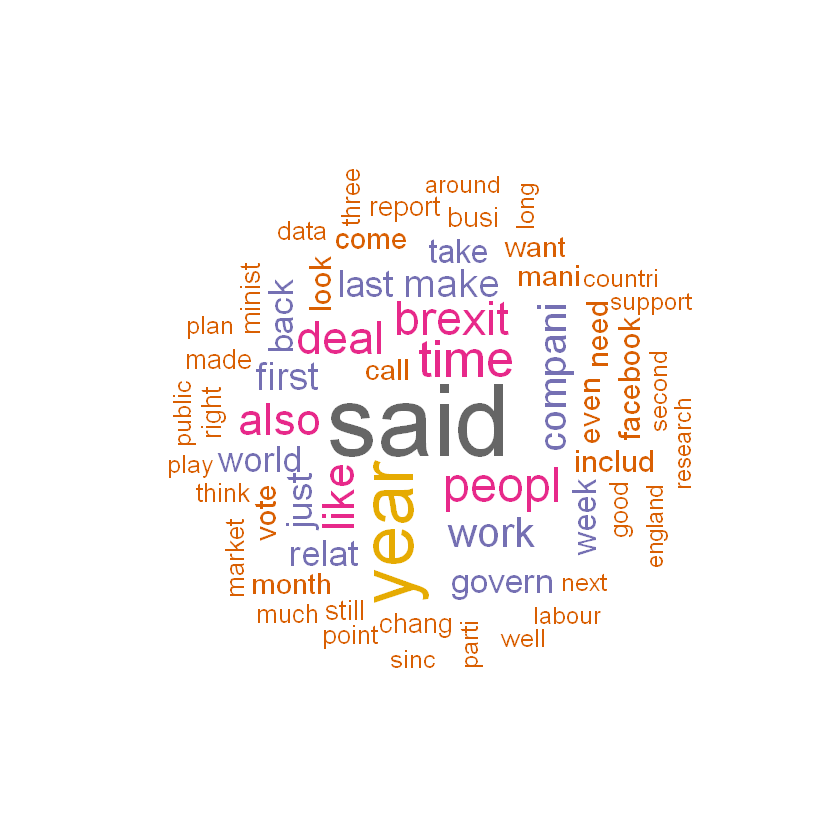

In [44]:
m1 = tdm_df
v1 = sort(rowSums(m1),decreasing = TRUE)
d1 = data.frame(word = names(v1),freq =v1)

wordcloud(words = d1$word, freq = d1$freq, min.freq = 1,
          scale=c(5,0.5), use.r.layout=FALSE,
          max.words=60, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

### Train Data

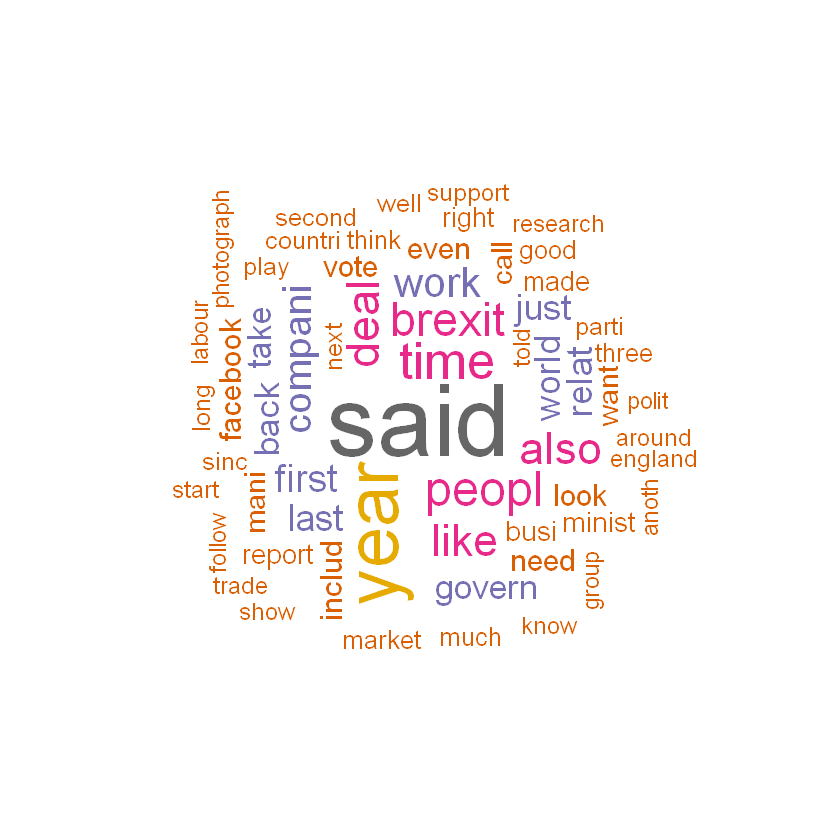

In [45]:
m2 = as.data.frame(as.matrix(tdm_train), stringsAsFactors=False)
v2 = sort(rowSums(m2),decreasing = TRUE)
d2 = data.frame(word = names(v2),freq =v2)

wordcloud(words = d2$word, freq = d2$freq, min.freq = 1,
          scale=c(5,0.5), use.r.layout=FALSE,
          max.words=60, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

### Test Data

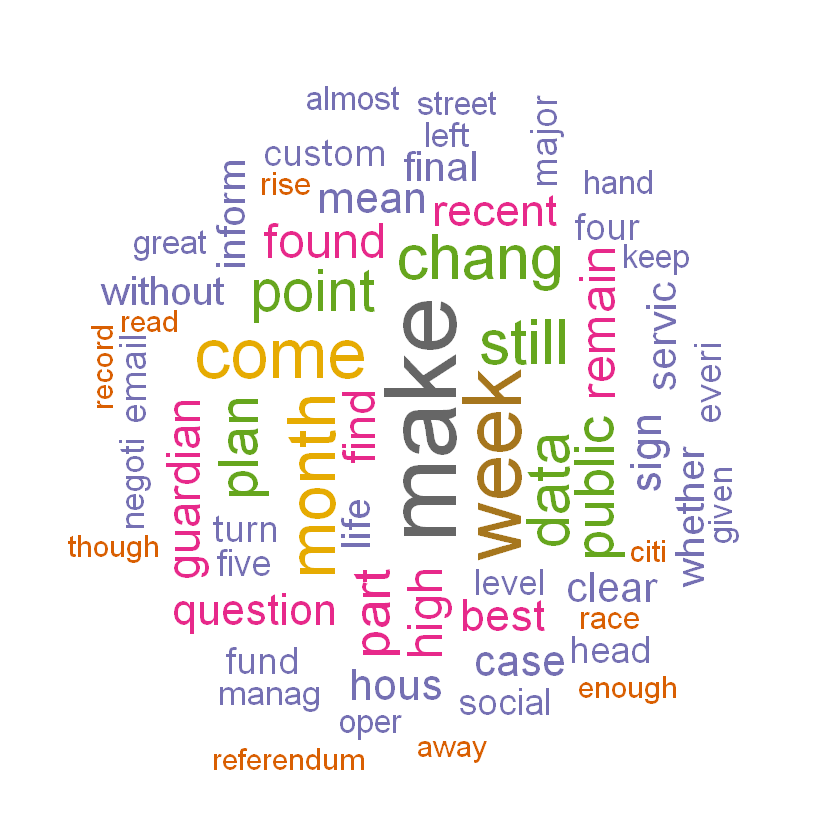

In [46]:
m3 = as.data.frame(as.matrix(tdm_test), stringsAsFactors=False)
v3 = sort(rowSums(m3),decreasing = TRUE)
d3 = data.frame(word = names(v3),freq =v3)

wordcloud(words = d3$word, freq = d3$freq, min.freq = 1,
          scale=c(5,0.5), use.r.layout=FALSE,
          max.words=60, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))